In [1]:
#%pip install scikit-learn

In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import random
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from sklearn.preprocessing import MinMaxScaler

In [2]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

In [3]:
def getTickerData(ticker, period, interval):
    hist = yf.download(tickers = ticker, period=period, interval=interval)
    df = pd.DataFrame(hist)
    df = df.reset_index()
    return df

In [4]:
df = getTickerData('btc-usd', '729d', '1h')
df = df.drop(columns={'Volume', 'Adj Close', 'Open', 'High', 'Low'})
df = df.rename(columns={'Close': 'close', 'Datetime': 'date', 'Date': 'date'})
#df['date'] = pd.to_datetime(df['date'])
df.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17232 entries, 0 to 17231
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    17232 non-null  datetime64[ns, UTC]
 1   close   17232 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 269.4 KB


36122.20703125


,date,close
659,2021-05-30 14:00:00+00:00,35347.593750
660,2021-05-30 15:00:00+00:00,35504.179688
661,2021-05-30 16:00:00+00:00,35706.031250
662,2021-05-30 17:00:00+00:00,35841.222656
663,2021-05-30 18:00:00+00:00,36132.812500


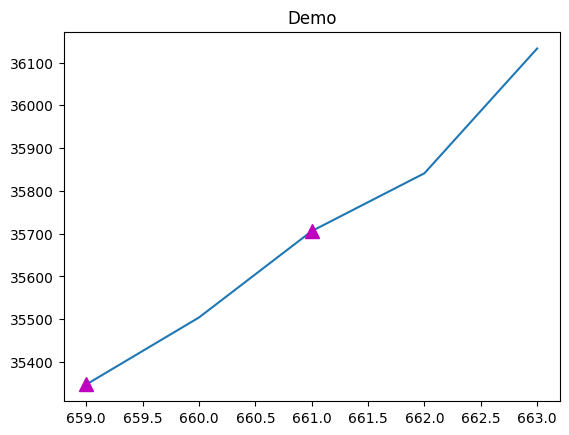

In [9]:
df2 = df.iloc[rn+i:rn+5+i,:]
final_value = df.loc[rn+5+i]['close']
close_value = df.loc[rn+4+i]['close']
plt.plot(df2['close'])
plt.plot(df2['close'], '^', markersize=10, color='m', label = 'buying signal', markevery = [True, False, True, False, False])
plt.title('Demo')
print(final_value)
i+=1
df2

In [298]:
class TradingEnv(Env):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__()        
        self.df = df.drop(columns={'date'})
        self.window_size = window_size
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(window_size, self.df.shape[1]), dtype=np.float64)
        self.action_space = Discrete(3) # 0-short pos || 1-long pos || 2-hold pos
        self.done = None
        
        self.current_step = 0
        self.n_steps = n_steps
        self.needed_space = self.window_size + self.n_steps
        self.random_index = random.randint(0, df.value_counts().sum() - self.needed_space-1)
        
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.next_value = df.iloc[self.random_index+self.window_size+self.current_step]['close']
        
        self.long_pos = []
        self.short_pos = []
        self.hold_pos = []
        self.current_pos = None
        self.held_price = 0
        self.in_a_pos = False
        
    def step(self, action):
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.next_value = df.iloc[self.random_index+self.window_size+self.current_step]['close']
            
        reward = self.calculate_reward(action)
            
        if action == 0:
            self.short_pos.append(True)
            self.long_pos.append(False)
            self.hold_pos.append(False)
            self.current_pos = action
            self.held_price = self.final_value
            self.in_a_pos = True
        elif action == 1:
            self.short_pos.append(False)
            self.long_pos.append(True)
            self.hold_pos.append(False)
            self.current_pos = action
            self.held_price = self.final_value
            self.in_a_pos = True
        else:
            self.short_pos.append(False)
            self.long_pos.append(False)
            self.hold_pos.append(True)      
        
        self.current_step += 1
        if self.current_step >= self.n_steps:
            done = True
        else:
            done = False
        
        observation = self.get_observation()
        info = {}
        
        return observation, reward, done, info
        
    def reset(self):
        next_observation = self.get_observation(is_random=True)
        self.random_index = random.randint(0, df.value_counts().sum() - self.needed_space-1)
        self.done = False
        self.current_step = 0
        self.long_pos.clear()
        self.short_pos.clear()
        self.hold_pos.clear()
        next_observation = self.get_observation(is_random=True)
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.next_value = df.iloc[self.random_index+self.window_size+self.current_step]['close']
        self.held_price = 0
        self.in_a_pos = False
        return next_observation
    
    def get_observation(self, is_random=False):
        if is_random:
            self.random_index = random.randint(0, df.value_counts().sum() - self.needed_space-1)
        return self.df.iloc[self.random_index+self.current_step:self.random_index+self.window_size+self.current_step, :].values
    
    def render_final(self):
        final_observation = self.df.iloc[self.random_index+self.window_size-1:self.random_index+self.window_size+self.n_steps]
        win_rate = sum(n == 1 for n in self.long_pos) / self.n_steps
        loss_rate = 1 - win_rate
        
        self.short_pos.append(False)
        self.long_pos.append(False)
        self.hold_pos.append(False)
        fig, ax = plt.subplots()
        plt.figure(figsize=(10,5))
        ax.plot(final_observation, color='c', lw=2.)
        ax.plot(final_observation, '^', markersize=10, color='g', label = 'buying signal', markevery = self.long_pos)
        ax.plot(final_observation, 'v', markersize=10, color='r', label = 'selling signal', markevery = self.short_pos)
        ax.plot(final_observation, 'o', markersize=10, color='b', label = 'holding signal', markevery = self.hold_pos)
        ax.set_title("Final result of the last trading session")
        ax.legend()
        ax.plot()
        
        return win_rate, loss_rate
    
    def calculate_reward(self, action):
        """Calculate the reward function for the model here
        Example:\n
        reward = 1\n
        return reward"""
        raise NotImplementedError    

In [308]:
class Trading(TradingEnv):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__(df, n_steps, window_size)
    
    def calculate_reward(self, action):
        reward = 0
        if action != 2 and self.in_a_pos:
            if self.current_pos == 0: 
                if self.final_value < self.held_price:
                    reward = 1
                else:
                    reward = -1  
            if self.current_pos == 1: 
                if self.final_value > self.held_price:
                    reward = 1
                else:
                    reward = -1
        return reward

In [309]:
env = Trading(df, window_size=90, n_steps=20)

In [310]:
check_env(env)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\env_checker.py:213: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


In [311]:
print(env.reset()[-1])

[33316.9765625]


33316.9765625
0


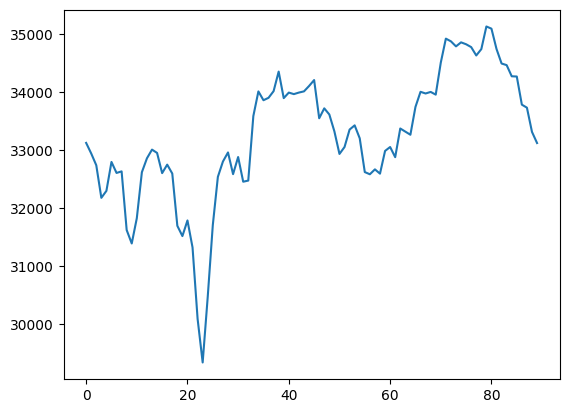

In [312]:
obs, reward, done, info = env.step(2)
plt.plot(obs)
print(env.final_value)
print(env.held_price)

0
0
1
-1
1
0
0
-1
0
0
-1
0
-1
0
1
-1
1
-1
1
-1
episode - 1 || score - -2


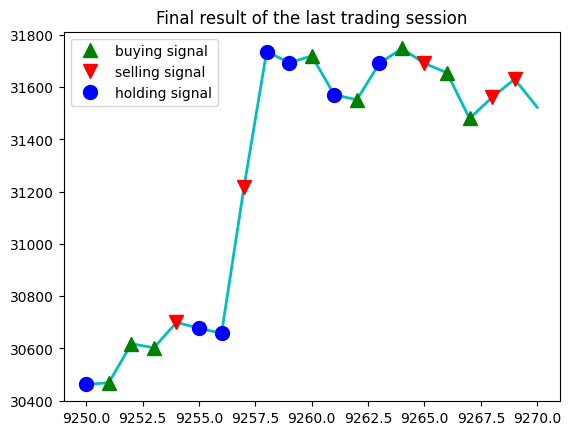

<Figure size 1000x500 with 0 Axes>

In [315]:
episodes = 1
for n in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    steps_taken = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        score += reward
        steps_taken+=1
        print(reward)
    win_rate, loss_rate = env.render_final()
    print(f'episode - {n} || score - {score}')

In [32]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [33]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [34]:
model = RecurrentPPO('MlpLstmPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.0001)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [35]:
model.learn(total_timesteps=30000, callback=callback)

Logging to ./logs/RecurrentPPO_6
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 0        |
| time/              |          |
|    fps             | 156      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 128      |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | 0.667        |
| time/                   |              |
|    fps                  | 128          |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 256          |
| train/                  |              |
|    approx_kl            | 6.618444e-06 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.693       |
|    explained_variance  

In [475]:
loaded_model = RecurrentPPO.load('./train/best_model_10000.zip')

In [537]:
evaluate_policy(loaded_model, env, n_eval_episodes=10)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(1.2, 4.4)

episode - 1 || score - 2


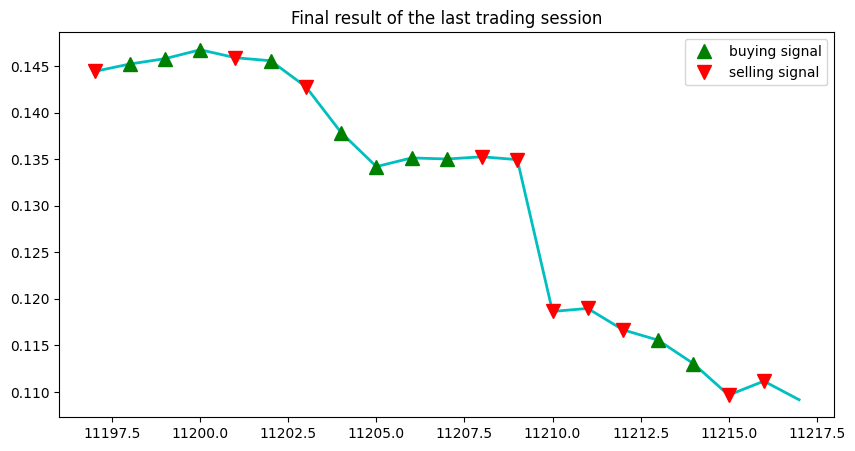

In [46]:
episodes = 1
for n in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    steps_taken = 0
    while not done:
        action, lstm_cells = model.predict(obs)
        obs, reward, done, info = env.step(action)
        score += reward
        steps_taken+=1
    env.render_final()
    print(f'episode - {n} || score - {score}')